# COMP90051 Workshop 5
## Support Vector Machines
***

In this section, we'll explore how the SVM hyperparameters (i.e. the penalty parameter, the kernel, and any kernel parameters) affect the decision surface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from timeit import default_timer as timer
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV

### 1. Data set
To make visualisation and training easy, we'll consider a small binary classification data set called `cats.csv` (available from the LMS). 
It contains observations for 150 cats.
There are two features: heart and body weight measured in kilograms.
The target variable is the sex of the cat (we encode 'male' as`-1` and 'female' as `+1`).

\[Note: the data set originates from the following paper: R. A. Fisher (1947) _The analysis of covariance method for the relation between a part and the whole_, Biometrics **3**, 65–68\]

Ensure that `cats.csv` is located in the same directory as this notebook, then run the following code block to read the CSV file using `pandas`.

In [2]:
full_df = pd.read_csv('cats.csv')
full_df.SEX = full_df.SEX.map({'M': -1, 'F': 1})
full_df.head()

,HWT,BWT,SEX
0,2.0,7.0,1
1,2.0,7.4,1
2,2.0,9.5,1
3,2.1,7.2,1
4,2.1,7.3,1


Let's split the data into train/test sets so that we can evaluate our trained SVM.
(Note that this is likely to be unreliable for such a small data set.)

In [3]:
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=1)

Since SVMs incorporate a penalty term for the weights (proportional to $\|\mathbf{w}\|_2^2$), it's usually beneficial to _standardise_ the features so that they vary on roughly the same scale.

***
**Exercise:** Complete the code block below to standardise the features, so that each feature has zero mean/unit variance.

_Hint: use `StandardScaler` imported above._
***

In [4]:
scaler = StandardScaler()
scaler.fit(train_df[['HWT', 'BWT']])
X_train = scaler.transform(train_df[['HWT', 'BWT']]) # fill in
y_train = train_df['SEX'] # fill in
scaler.fit(test_df[['HWT', 'BWT']])
X_test = scaler.transform(test_df[['HWT', 'BWT']]) # fill in
y_test = test_df['SEX'] # fill in

Let's plot the training data. Notice that it's not linearly separable.

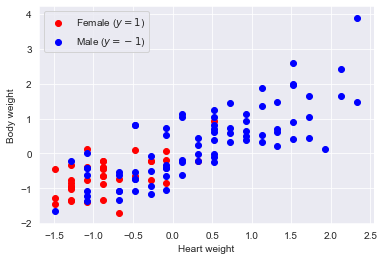

In [9]:
plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], label="Female ($y=1$)", c='r')
plt.scatter(X_train[y_train==-1,0], X_train[y_train==-1,1], label="Male ($y=-1$)", c='b')
plt.xlabel("Heart weight")
plt.ylabel("Body weight")
plt.legend()
plt.show()

### 2. Parameter grid search
Since the data is clearly not linearly separable, we're going to fit a kernelised SVM.
To do this, we'll use the `sklearn.svm.SVC` class, which is a wrapper for the popular [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) library.
\[Aside: LIBSVM solves the dual problem using a variant of the [sequential minimal optimisation (SMO) algorithm](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf).\]
The corresponding primal problem is as follows:

$$
\begin{align}
\min_{\mathbf{w}, b, \xi} \phantom{=} & \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{i = 1}^{n} \xi_i \\
      \mathrm{subject~to} \phantom{=} & y_{i}(\mathbf{w}^T \cdot \phi(\mathbf{x_i}) + b) \geq 1 - \xi_i \\
                          \phantom{=} & \xi_i \geq 0 \ \forall i
\end{align}
$$

Here $C$ is the penalty parameter, $\mathbf{w}$ are the weights, $b$ is the bias and $\phi$ is a mapping to a higher dimensional space---related to the kernel through $K(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j) \rangle$.
For now, we'll use the radial basis function (RBF) kernel, which is parameterised in terms of $\gamma$ as follows:

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2)
$$

Returning to our classification problem: it's unclear how to set appropriate values for $C$ and $\gamma$ (named `C` and `gamma` in `sklearn`).
A simple way around this is to do an exhaustive cross validation grid search.
Below we define an evenly-spaced grid in log-space.

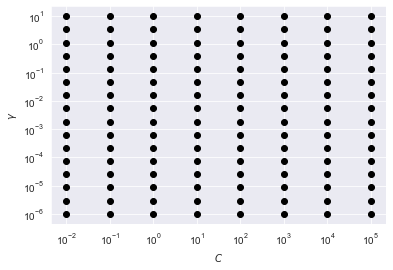

In [10]:
C_range = np.logspace(-2, 5, 8)
gamma_range = np.logspace(-6, 1, 16)

# Visualise the grid
xx, yy = np.meshgrid(C_range, gamma_range)
plt.plot(xx, yy, 'ko')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$C$')
plt.ylabel(r'$\gamma$')
plt.show()

To do the grid search, we'll use the built-in `sklearn.model_selection.GridSearchCV` class.
It evaluates the model for each combination of parameter values using cross validation, and selects the combination with the best score.

We'll use `StratifiedShuffleSplit` for cross validation (it effectively generates bootstrap samples from the training data, while preserving the class ratio).

In [11]:
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.1, random_state=1)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid={'gamma': gamma_range, 'C': C_range}, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are {0.best_params_} with an accuracy of {0.best_score_:.3g}".format(grid))

The best parameters are {'C': 10.0, 'gamma': 0.04641588833612782} with an accuracy of 0.828


***
**Question:** Why aren't we using k-fold cross validation?
***

Below we visualise the cross validation accuracy over the grid of parameters.

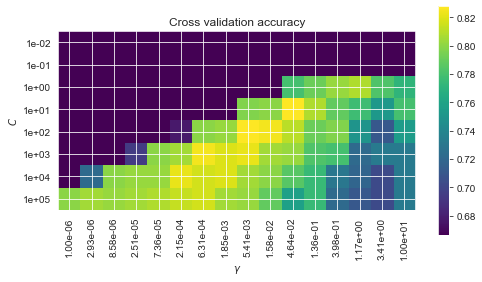

In [13]:
scores = grid.cv_results_['mean_test_score'].reshape(C_range.size, gamma_range.size)

plt.figure(figsize=(8, 6))
plt.imshow(scores, cmap='viridis')
plt.colorbar(shrink=0.7)
plt.xticks(np.arange(len(gamma_range)), ["%.2e" % gamma for gamma in gamma_range], rotation=90)
plt.yticks(np.arange(len(C_range)), ["%1.e" % C for C in C_range])
plt.title('Cross validation accuracy')
plt.xlabel(r'$\gamma$')
plt.ylabel('$C$')
plt.show()

***
**Question:** Interpret this plot. Is there a clear winning combination of parameters?
***

Now that we've found the "best" parameters, let's fit the SVM on the entire training set (without cross-validation).

(Note: we actually fit all parameter combinations, as they're needed for a plot generated below.)

In [14]:
classifiers = {(C, gamma) : SVC(C=C, gamma=gamma, kernel='rbf').fit(X_train, y_train) 
               for C in C_range
               for gamma in gamma_range}

Below we evaluate the "best" classifier on the test set.

In [15]:
best_params = (grid.best_params_["C"], grid.best_params_["gamma"])
best_svm = classifiers[best_params]
best_train_acc = best_svm.score(X_train, y_train)
best_test_acc = best_svm.score(X_test, y_test) 
print("The SVM with parameters C={0[0]:.3g}, gamma={0[1]:.3g} has training accuracy {1:.3g} and test accuracy {2:.3g}.".format(best_params, best_train_acc, best_test_acc))

The SVM with parameters C=10, gamma=0.0464 has training accuracy 0.817 and test accuracy 0.724.


***
**Question:** How does this compare to the training accuracy?
***

Below we visualise the decision functions for all parameter combinations (double-click output to expand to 100%)

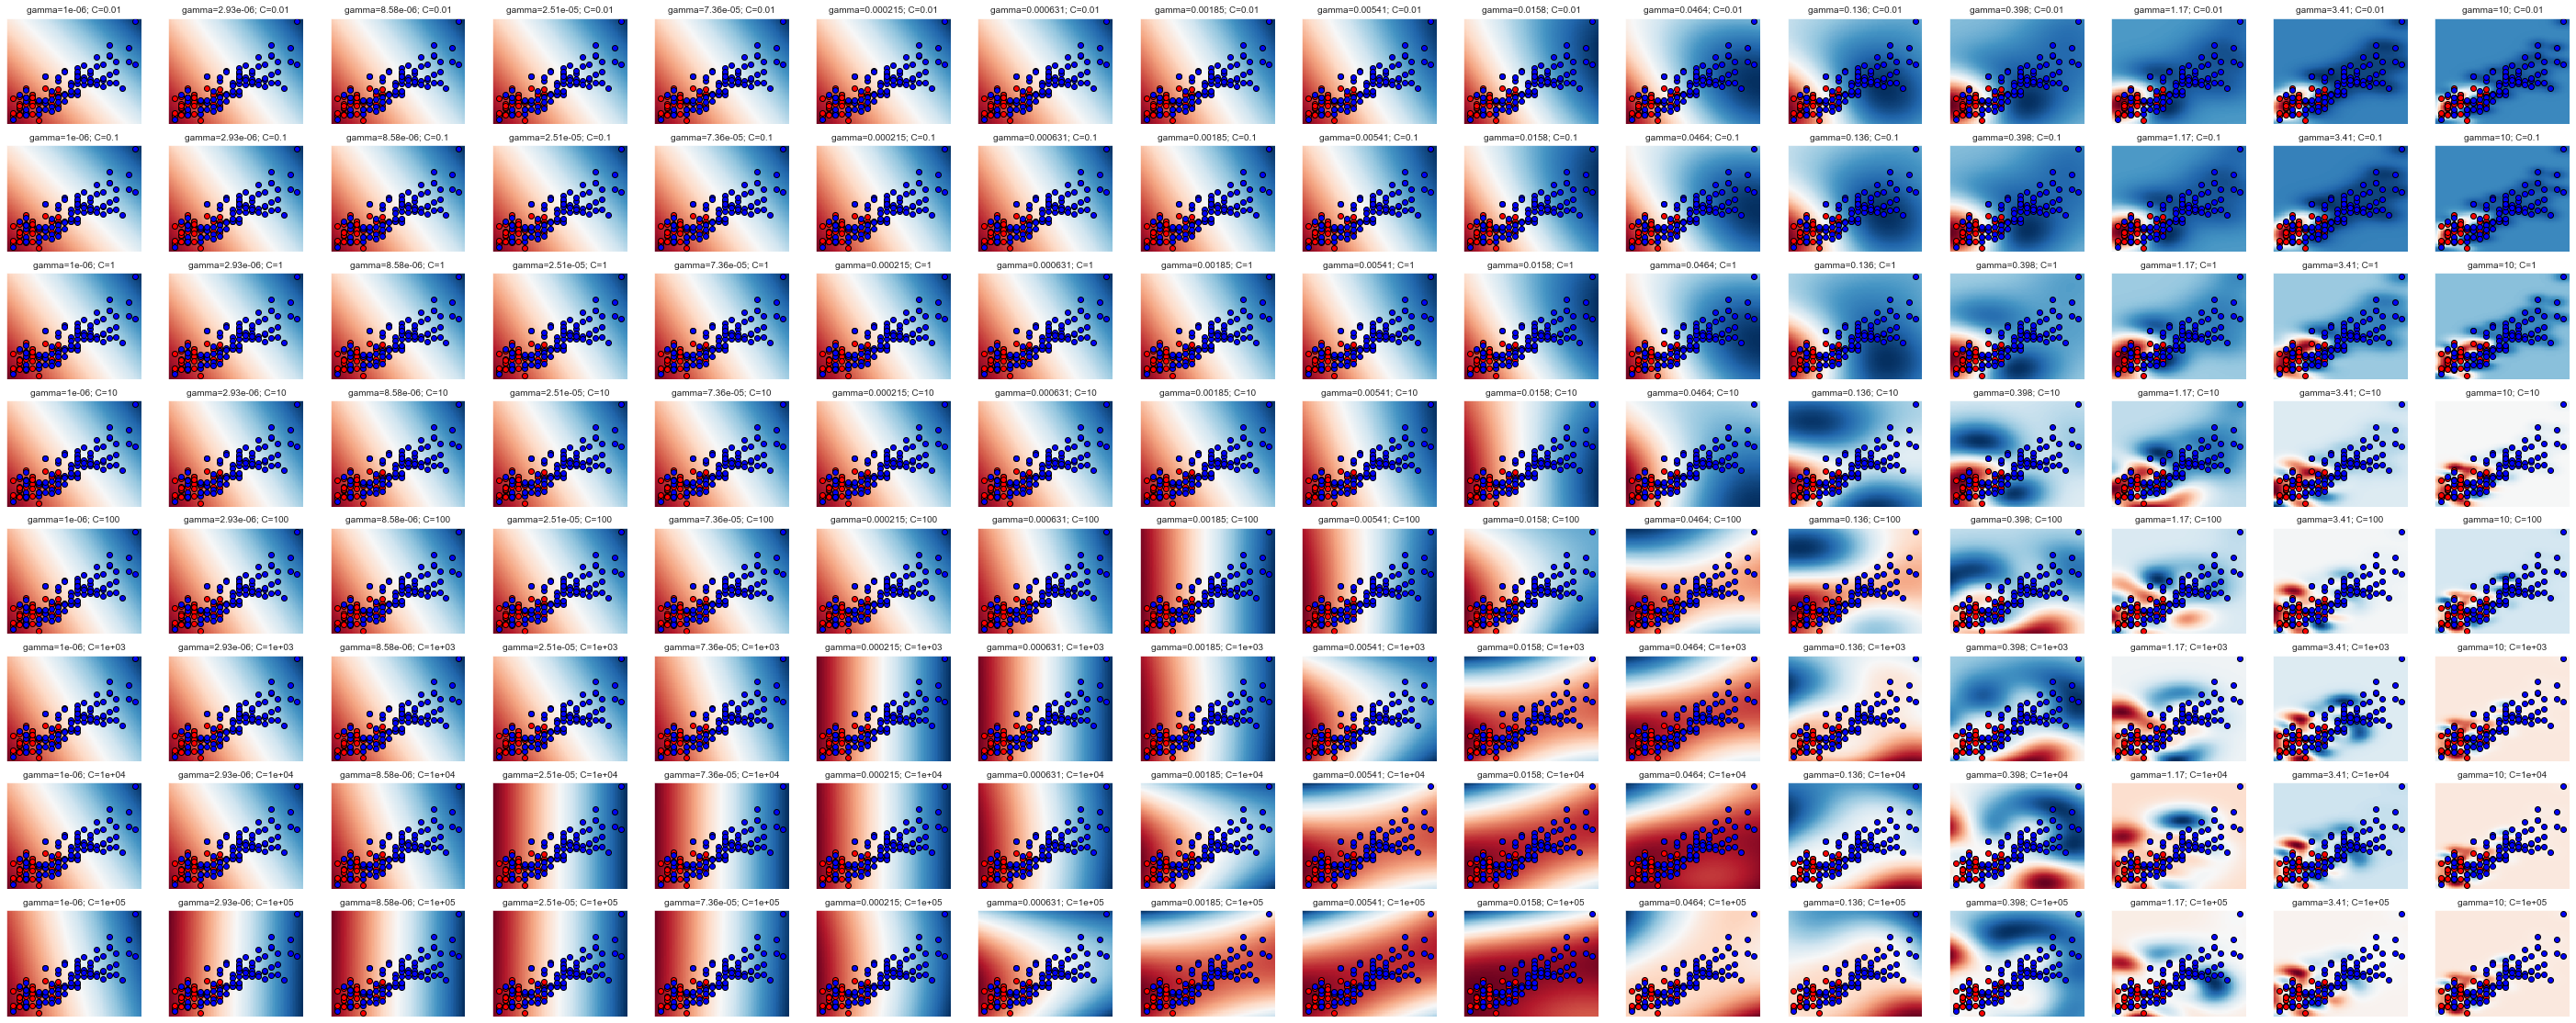

In [16]:
fig, ax = plt.subplots(C_range.size, gamma_range.size, figsize=(50,20))
border = 0.2

# Build meshgrid over the feature space
X_min = np.amin(X_train, axis=0)
X_max = np.amax(X_train, axis=0)
xx, yy = np.meshgrid(np.linspace(X_min[0] - border, X_max[0] + border, 100), 
                     np.linspace(X_min[1] - border, X_max[1] + border, 100))

# Plot training data + decision function for all feature combinations
for (i, C) in enumerate(C_range):
    for (j, gamma) in enumerate(gamma_range):
        clf = classifiers[(C, gamma)]
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax[i,j].set_title("gamma={0.gamma:.3g}; C={0.C:.3g}".format(clf), 
                           size='medium')

        ax[i,j].pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
        ax[i,j].scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='r', edgecolors='k')
        ax[i,j].scatter(X_train[y_train==-1,0], X_train[y_train==-1,1], c='b', edgecolors='k')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].axis('tight')
plt.show()

***
**Question:** Explain how `gamma` and `C` affect the decision surface qualitatively.

**Extension activity:** Re-run this section using a different kernel (e.g. the built-in polynomial kernel or a custom kernel).
***